In [ ]:
# todo:
# test on other simple datasets eg fmnist
# test on very small segment len eg 0.5s
# try without scaling data? idk what this would entail or if this even makes sense
# start second part if vae still will not work


# For artifact removal/general use
!pip3 install MNE

import random
import numpy as np
import mne
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets

# For seizure detection
!pip3 install ncps
!pip3 install pytorch_lightning

from ncps.wirings import AutoNCP
from ncps.torch import LTC
import pytorch_lightning as pl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from typing_extensions import dataclass_transform
filter_low = 0.5
filter_high = 40.0

class EEGDataset(Dataset):
  def __init__(self, files, channels, segment_len, interval, transform, scale):
    self.data = []
    self.details = []
    self.raws = []
    self.times = []

    for i in range(len(files)):
      raw = mne.io.read_raw_edf(files[i], preload=True)
      raw.filter(l_freq=filter_low, h_freq=filter_high)
      self.raws.append(raw)

    sampling_freq = raw.info["sfreq"]

    interval_adjusted = (interval * sampling_freq)
    segment_len_adjusted = segment_len * sampling_freq

    sum = 0
    for i in range(len(self.raws)):

      data, times = self.raws[i].get_data(picks=channels, return_times=True)
      data = scale * data
      print("min: {}, max: {}, range: {}".format(data.min(), data.max(), data.max()-data.min()))
      sum += (data.max()-data.min())
      data = np.interp(data, (data.min(), data.max()), (0, scale))
      start_time = 0
      while start_time < len(self.raws[i]):
        end_time = start_time + segment_len_adjusted

        data_spliced = data[channels : channels+1, int(start_time) : int(end_time)]
        times_spliced = times[int(start_time) : int(end_time)]

        if data_spliced.size == segment_len*256:
          self.data.append(data_spliced)
          self.times.append(times_spliced)
          self.details.append((i, start_time, times[int(start_time)]))
        start_time += interval_adjusted

    sum /= len(self.raws)
    print(sum)

    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    sample = self.data[idx]
   # sample = to_image(sample[0])

    if self.transform:
      sample = self.transform(sample)

    #sample = sample.view(-1, 768)

    return sample

  def plot(self, idx):
    x = self.times[idx]
    y = self.data[idx][0].T
    plt.plot(x, y, color="black")

In [ ]:
BATCH_SIZE = 16
CHANNEL_NUM = 0
SEGMENT_LEN = 1
INTERVAL = 1

training_files = []
testing_files = []


for i in range(8):
  training_files.append("drive/MyDrive/Synopsys/Data/chb01_0{}.edf".format(i+1))

training_files.append("drive/MyDrive/Synopsys/Data/chb01_10.edf")
training_files.append("drive/MyDrive/Synopsys/Data/chb01_16.edf")

for i in range(5):
  testing_files.append("drive/MyDrive/Synopsys/Data/chb01_{}.edf".format(i+11))

In [ ]:
SCALE = 1

# todo: normalize data so sigmoid outputs are more varied in decoder final layer

transf = transforms.Compose([transforms.ToTensor()]) # transforms.Pad([2])
training_data = EEGDataset(training_files, CHANNEL_NUM, SEGMENT_LEN, INTERVAL, transf, SCALE)#datasets.MNIST("./data", train=True, download=True, transform=transf)#

testing_data = EEGDataset(testing_files, CHANNEL_NUM, SEGMENT_LEN, INTERVAL, transf, SCALE)#datasets.MNIST("./data", train=True, download=True, transform=transf)

train_loader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)

test_loader = DataLoader(testing_data, batch_size=BATCH_SIZE)

Extracting EDF parameters from /content/drive/MyDrive/Synopsys/Data/chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-3-01d42bfa3ee9>:13: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(files[i], preload=True)


Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.3s


Extracting EDF parameters from /content/drive/MyDrive/Synopsys/Data/chb01_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-3-01d42bfa3ee9>:13: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(files[i], preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.2s


Extracting EDF parameters from /content/drive/MyDrive/Synopsys/Data/chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-3-01d42bfa3ee9>:13: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(files[i], preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.3s


Extracting EDF parameters from /content/drive/MyDrive/Synopsys/Data/chb01_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-3-01d42bfa3ee9>:13: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(files[i], preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Extracting EDF parameters from /content/drive/MyDrive/Synopsys/Data/chb01_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-3-01d42bfa3ee9>:13: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(files[i], preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.1s


Extracting EDF parameters from /content/drive/MyDrive/Synopsys/Data/chb01_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-3-01d42bfa3ee9>:13: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(files[i], preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.5s


Extracting EDF parameters from /content/drive/MyDrive/Synopsys/Data/chb01_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-3-01d42bfa3ee9>:13: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(files[i], preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.4s


Extracting EDF parameters from /content/drive/MyDrive/Synopsys/Data/chb01_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-3-01d42bfa3ee9>:13: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(files[i], preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.3s


Extracting EDF parameters from /content/drive/MyDrive/Synopsys/Data/chb01_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-3-01d42bfa3ee9>:13: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(files[i], preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


Extracting EDF parameters from /content/drive/MyDrive/Synopsys/Data/chb01_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-3-01d42bfa3ee9>:13: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(files[i], preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.2s


min: -0.0007607393730174395, max: 0.0009499344691269651, range: 0.0017106738421444046
min: -0.0005786290410592225, max: 0.0007167518855540397, range: 0.0012953809266132623
min: -0.00048530847467289327, max: 0.0004982244239569824, range: 0.0009835328986298757
min: -0.0004778738912327796, max: 0.0008109858760726228, range: 0.0012888597673054024
min: -0.0007446710006425866, max: 0.0008618667731512327, range: 0.0016065377737938193
min: -0.00074415148249591, max: 0.001095046010412977, range: 0.001839197492908887
min: -0.000849270710874446, max: 0.001033434339709675, range: 0.001882705050584121
min: -0.0005329832397401905, max: 0.0008705892567013877, range: 0.0014035724964415782
min: -0.0008305112593673734, max: 0.0008097819445524815, range: 0.0016402932039198549
min: -0.000574008793508177, max: 0.0005713027190105697, range: 0.0011453115125187466
0.001479606496485995
Extracting EDF parameters from /content/drive/MyDrive/Synopsys/Data/chb01_11.edf...
EDF file detected
Setting channel info str

<ipython-input-3-01d42bfa3ee9>:13: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(files[i], preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s


Extracting EDF parameters from /content/drive/MyDrive/Synopsys/Data/chb01_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-3-01d42bfa3ee9>:13: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(files[i], preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.1s


Extracting EDF parameters from /content/drive/MyDrive/Synopsys/Data/chb01_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-3-01d42bfa3ee9>:13: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(files[i], preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.1s


Extracting EDF parameters from /content/drive/MyDrive/Synopsys/Data/chb01_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-3-01d42bfa3ee9>:13: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(files[i], preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s


Extracting EDF parameters from /content/drive/MyDrive/Synopsys/Data/chb01_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-3-01d42bfa3ee9>:13: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(files[i], preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


min: -0.0005410645331852238, max: 0.0008178522750440189, range: 0.0013589168082292426
min: -0.0006024722436136185, max: 0.000767508776697669, range: 0.0013699810203112875
min: -0.0004419624793959821, max: 0.0008316431003862691, range: 0.0012736055797822512
min: -0.0004723657923019761, max: 0.000780746272969582, range: 0.0012531120652715581
min: -0.0004621946445001568, max: 0.0003082500953305417, range: 0.0007704447398306985
0.0012052120426850076


In [ ]:
class VAE(nn.Module):
  def __init__(self, channels, input_dim, latent_dim, beta, gamma):
    super().__init__()

    self.latent_dim = latent_dim

    self.beta = beta
    self.gamma = gamma

    channels_enc = channels

    self.encoder = nn.Sequential()
    self.channels = channels
    self.layers = len(channels)
    self.linear_dim = input_dim**2
    #self.linear_dim = int((32/2**self.layers)**2*channels[-1])

    for i in range(self.layers):
      self.encoder.append(nn.Conv2d(1 if i == 0 else channels_enc[i-1], channels_enc[i], kernel_size=3, stride=2, padding=1))
      self.encoder.append(nn.BatchNorm2d(channels_enc[i]))
      self.encoder.append(nn.ReLU())

    self.decoder = nn.Sequential()

    self.linear = nn.Linear(latent_dim, self.linear_dim)

    channels_dec = channels[::-1]

    for i in range(self.layers):
      self.decoder.append(nn.ConvTranspose2d(channels_dec[i] if i == 0 else channels_dec[i-1], channels_dec[i], kernel_size=3, stride=2, padding=1, output_padding=1))
      self.decoder.append(nn.BatchNorm2d(channels_dec[i]))
      self.decoder.append(nn.ReLU())

    self.decoder.append(nn.Conv2d(channels[0], 1, kernel_size=3, stride=1, padding=1))
    self.decoder.append(nn.Sigmoid())

    self.mu = nn.Linear(self.linear_dim, latent_dim)
    self.log_var = nn.Linear(self.linear_dim, latent_dim)
    self.double()

  def encode(self, x):
    encoded = self.encoder(x)
    encoded = torch.flatten(encoded, 1)
    mu = self.mu(encoded)
    log_var = self.log_var(encoded)

    return [mu, log_var]

  def decode(self, x):
    x = self.linear(x)
    x = x.reshape(-1, self.channels[-1], 1, 1) # todo: come up with expression so number (eg4) does not have to be hardcoded
    decoded = self.decoder(x)
    return decoded

  def reparameterize(self, mu, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    return mu + std * eps

  def forward(self, x):
    mu, log_var = self.encode(x)
    z = self.reparameterize(mu, log_var)

    return [x, z, self.decode(z), mu, log_var]

  def calc_loss(self, input, reconstructed, mu, log_var, train):
    recons_loss = F.mse_loss(reconstructed, input, reduction="sum")
    #recons_loss = F.binary_cross_entropy(reconstructed, input, reduction="sum")

    kld_loss = -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp())

    # todo: add beta parameter using the "correct" physical model

    loss = recons_loss
    if train:
      loss = self.beta * loss
      loss = loss + kld_loss #self.beta * kld_loss
    else:
      loss = loss + kld_loss
    # loss = recons_loss + self.gamma * (kld_loss - C).abs()
      #print("{}, {}, {}".format(recons_loss.data, kld_loss.data, loss.data))
    return [loss, recons_loss]

In [ ]:
class AE(nn.Module):
  def __init__(self, channels, input_dim, latent_dim, beta, gamma):
    super().__init__()

    self.latent_dim = latent_dim

    self.beta = beta
    self.gamma = gamma

    channels_enc = channels

    self.encoder = nn.Sequential()
    self.channels = channels
    self.layers = len(channels)
    self.linear_dim = input_dim**2
    #self.linear_dim = int((32/2**self.layers)**2*channels[-1])

    for i in range(self.layers):
      self.encoder.append(nn.Conv2d(1 if i == 0 else channels_enc[i-1], channels_enc[i], kernel_size=3, stride=2, padding=1))
      self.encoder.append(nn.BatchNorm2d(channels_enc[i]))
      self.encoder.append(nn.ReLU())


    self.linear_enc = nn.Linear(self.linear_dim, latent_dim)

    self.decoder = nn.Sequential()

    self.linear = nn.Linear(latent_dim, self.linear_dim)

    channels_dec = channels[::-1]

    for i in range(self.layers):
      self.decoder.append(nn.ConvTranspose2d(channels_dec[i] if i == 0 else channels_dec[i-1], channels_dec[i], kernel_size=3, stride=2, padding=1, output_padding=1))
      self.decoder.append(nn.BatchNorm2d(channels_dec[i]))
      self.decoder.append(nn.ReLU())

    self.decoder.append(nn.Conv2d(channels[0], 1, kernel_size=3, stride=1, padding=1))
    self.decoder.append(nn.Sigmoid())


    self.double()

  def encode(self, x):
    encoded = self.encoder(x)
    encoded = torch.flatten(encoded, 1)
    encoded = self.linear_enc(encoded)

    return encoded

  def decode(self, x):
    x = self.linear(x)
    x = x.reshape(-1, self.channels[-1], 1, 1) # todo: come up with expression so number (eg4) does not have to be hardcoded
    decoded = self.decoder(x)
    return decoded


  def forward(self, x):
    encoded = self.encode(x)

    return [x, encoded, self.decode(encoded), -1, -1]

  def calc_loss(self, input, reconstructed, mu, log_var, train):
    recons_loss = F.mse_loss(reconstructed, input, reduction="sum")
    #recons_loss = F.binary_cross_entropy(reconstructed, input, reduction="sum")

    # todo: add beta parameter using the "correct" physical model
    return [recons_loss, recons_loss]

In [ ]:
CHANNELS = [32, 64, 128, 256]
LATENT_DIM = 10
BETA = 0.5
GAMMA = -1
LEARNING_RATE = 0.001
INPUT_DIM = 16

In [ ]:
def train(model):
  train_loss = 0
  last_loss = 0

  model.train()

  for idx, (data) in enumerate(train_loader):
    data = data.view(-1, 1, INPUT_DIM, INPUT_DIM)
    data = data.to(device)
    input, encoded, output, mu, log_var = model(data)
    loss, recons_loss = model.calc_loss(input, output, mu, log_var, True)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    # if idx % 1000 == 999:
    #   last_loss = train_loss / 1000
    #   print("Batch {} loss: {}".format(idx+1, last_loss))
    #   train_loss = 0


  return train_loss

In [ ]:
def test(model):
  test_loss = 0
  test_rloss = 0

  model.eval()

  with torch.no_grad():
    for idx, (data) in enumerate(test_loader):
      data = data.view(-1, 1, INPUT_DIM, INPUT_DIM)
      data = data.to(device)
      input, encoded, output, mu, log_var = model(data)
      loss, recons_loss = model.calc_loss(input, output, mu, log_var, False)
      test_loss += loss.item()
      test_rloss += recons_loss.item()

  return [test_loss, test_rloss]


In [ ]:
def train_model(model):
  epochs = 20
  best_loss = 10000000
  best_rloss = 10000000

  for i in range(epochs):
    train_loss = train(model)
    test_loss, test_rloss = test(model)

    train_loss /= len(training_data)
    test_loss /= len(testing_data)
    test_rloss /= len(testing_data)

    if test_loss < best_loss or test_rloss < best_rloss:
      best_loss = min(test_loss, best_loss)
      best_rloss = min(test_rloss, best_rloss)
      # Naming format: model_{latent_dim}_{beta}_{index}_{mse+kld}_{mse}
      model_path = "model_{}_{}_{}_{}_{}".format(model.latent_dim, model.beta, i, f'{test_loss:.4f}', f'{test_rloss:.4f}')
      torch.save(model.state_dict(), model_path)

    print("Epoch {}, Train Loss: {}, Test Loss: {}, Test Loss (no KLD): {}".format(i, train_loss, test_loss, test_rloss))

In [ ]:
modelAE = AE(CHANNELS, INPUT_DIM, LATENT_DIM, -1, -1).to(device)
optimizer = optim.Adam(modelAE.parameters(), lr=LEARNING_RATE)

train_model(modelAE)

Epoch 0, Train Loss: 0.21355115204866212, Test Loss: 0.19891575806398876, Test Loss (no KLD): 0.19891575806398876
Epoch 1, Train Loss: 0.13418401073368186, Test Loss: 0.18531603972152083, Test Loss (no KLD): 0.18531603972152083
Epoch 2, Train Loss: 0.11608303698509334, Test Loss: 0.20067559072348348, Test Loss (no KLD): 0.20067559072348348
Epoch 3, Train Loss: 0.10484642193436852, Test Loss: 0.2120212427865644, Test Loss (no KLD): 0.2120212427865644
Epoch 4, Train Loss: 0.09586191575978362, Test Loss: 0.18313603064058984, Test Loss (no KLD): 0.18313603064058984
Epoch 5, Train Loss: 0.09185021637120597, Test Loss: 0.14753466513599256, Test Loss (no KLD): 0.14753466513599256
Epoch 6, Train Loss: 0.0870454311027483, Test Loss: 0.1437054416574167, Test Loss (no KLD): 0.1437054416574167
Epoch 7, Train Loss: 0.08338715122837387, Test Loss: 0.24530761506744592, Test Loss (no KLD): 0.24530761506744592
Epoch 8, Train Loss: 0.08076594704360535, Test Loss: 0.13622951041873713, Test Loss (no KLD):

In [ ]:
modelVAE = VAE(CHANNELS, INPUT_DIM, 10, BETA, -1).to(device)
optimizer = optim.Adam(modelVAE.parameters(), lr=LEARNING_RATE)

train_model(modelVAE)

In [ ]:
#model_path = "drive/MyDrive/Synopsys/Models/model_10_1_7_0.0095_0.0095"
model_path = "drive/MyDrive/Synopsys/Models/model_10_-1_18_0.1240_0.1240"
#model_path = "drive/MyDrive/Synopsys/Models/model_10_2_7_0.3246_0.3246"

loaded_model = AE(CHANNELS, INPUT_DIM, 10, 1, GAMMA).to(device)
loaded_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
loaded_model.eval()

loaded_model

AE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
  )
  (linear_enc): Linear(in_features=256, out_features=10, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, mo

In [ ]:
beta = 1.5
dim = 5
while beta <= 2:
  while dim <= 20:
    if not(beta == 1.5 and dim == 5):
      model = VAE(CHANNELS, dim, beta, -1).to(device)
      optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
      train_model(model)

    dim += 5
  dim = 5
  beta += 0.5

In [ ]:
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA

pca = PCA(n_components=2)

encoded = [] # (36,000 x 10)
labels = []

for i in range(len(training_data)):
  x = training_data.__getitem__(i).view(-1, 1, INPUT_DIM, INPUT_DIM).to(device)
  (_, z, _, _, _) = loaded_model(x)
  z = z.detach().cpu()[0]
  encoded.append(z.numpy())


In [ ]:
mean = np.mean(encoded, axis=0)
std = np.std(encoded, axis=0)

encoded = (encoded - mean) / std
reduction = pca.fit_transform(encoded) # (36,000 x 2)

In [ ]:
index = 7

test_point = training_data.__getitem__(index).view(-1, 1, INPUT_DIM, INPUT_DIM).to(device)
(_, z, _, _, _) = loaded_model(test_point)
z = z.cpu().detach().numpy()
z = (z - mean) / std

print(z)
r = pca.transform(z)

[[ 1.82480717 -1.18959144 -1.15777737  1.01132074  0.42669919 -0.38013279
  -0.81532762  1.68766661 -1.95111562 -0.65402238]]


In [ ]:
print(r[0])
print(reduction[31])

[0.85113715 0.90332707]
[0.85113715 0.90332707]


In [ ]:
outliers = []
for i in range(len(reduction)):
  if (np.abs(reduction[i][0]) > 0.7 or np.abs(reduction[i][1]) > 1.7):
    outliers.append(i)

In [ ]:
def plot_latent(data, labels, num_batches):
  plt.scatter(data[:, 0][: num_batches], data[:, 1][: num_batches], c='blue')
  for i in range(len(outliers)):
    if outliers[i] > num_batches:
      break
    plt.scatter(data[outliers[i]][0], data[outliers[i]][1], c='red')

  plt.scatter(r[0][0], r[0][1], c='green')
  #plt.colorbar()

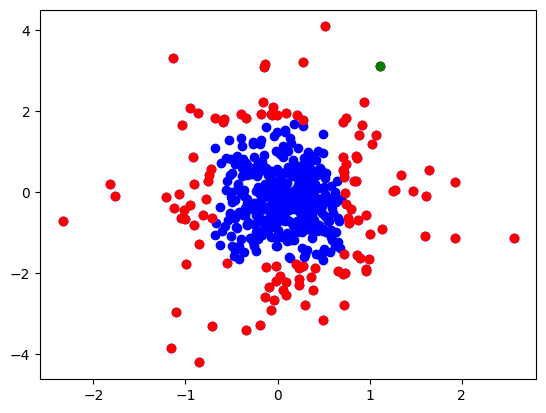

In [ ]:
plot_latent(reduction, labels, 500)

7
(0, 1792.0, 7.0)
tensor(0.4632, dtype=torch.float64)
tensor([0.4632], dtype=torch.float64)


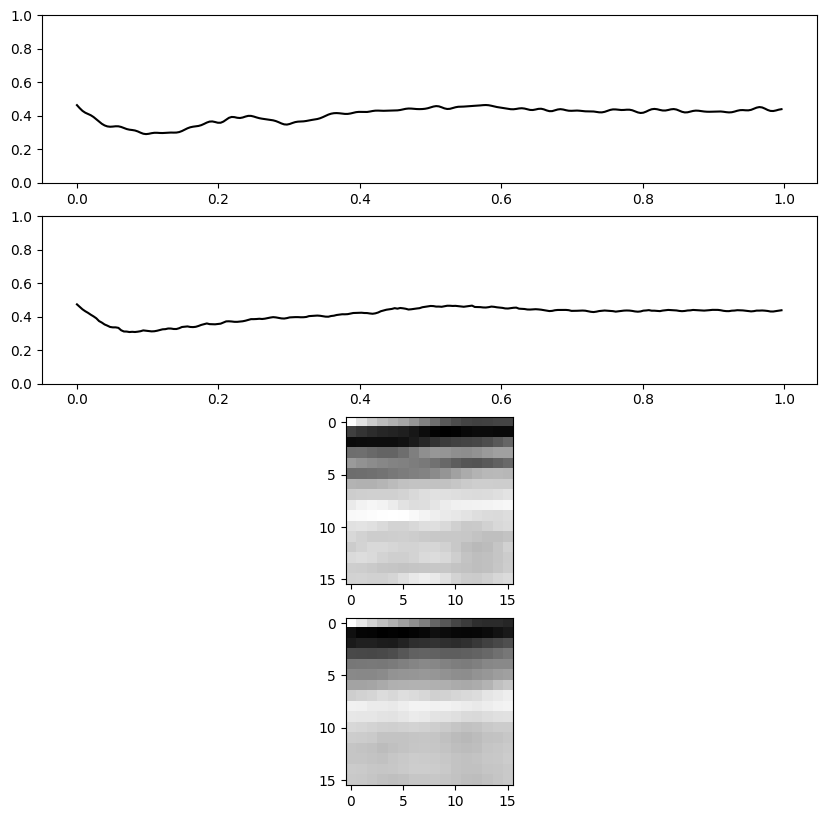

In [ ]:
#test_item = random.randint(0, 36000)
test_item = 7
item = training_data.__getitem__(test_item)[0].view(-1, 1, INPUT_DIM, INPUT_DIM).to(device)

print(test_item)
print(training_data.details[test_item])

(_, _, result, _, _) = loaded_model(item)

print(item.detach().cpu().data[0][0].view(INPUT_DIM, INPUT_DIM)[0][0])
print(item.detach().cpu().data[0][0].view(INPUT_DIM**2, -1)[0])

f, axarr = plt.subplots(4,1, figsize=(10, 10))
axarr[0].set_ylim([0, 1])
axarr[1].set_ylim([0, 1])
axarr[0].plot(training_data.times[0], item.detach().cpu().data[0][0].view(INPUT_DIM**2, -1), color="black")
axarr[1].plot(training_data.times[0], result.detach().cpu().data[0][0].view(INPUT_DIM**2, -1), color="black")
axarr[2].imshow(item.detach().cpu().data[0][0].view(INPUT_DIM, INPUT_DIM), cmap="gray")
axarr[3].imshow(result.detach().cpu().data[0][0], cmap="gray")

In [ ]:
print(outliers)

[0, 5, 7, 10, 25, 26, 27, 28, 29, 31, 44, 51, 52, 59, 60, 67, 71, 78, 87, 89, 92, 98, 99, 113, 125, 133, 134, 135, 138, 139, 140, 145, 146, 149, 150, 151, 156, 159, 160, 164, 168, 170, 171, 173, 176, 179, 180, 188, 189, 195, 204, 211, 212, 221, 230, 236, 238, 241, 242, 249, 262, 263, 267, 270, 272, 276, 297, 298, 301, 305, 307, 314, 316, 317, 330, 332, 339, 340, 350, 355, 364, 376, 381, 390, 391, 399, 401, 409, 414, 415, 416, 417, 420, 423, 425, 434, 435, 437, 440, 443, 446, 448, 456, 457, 458, 459, 460, 464, 468, 469, 471, 472, 481, 488, 490, 493, 495, 501, 504, 517, 518, 526, 531, 535, 538, 557, 559, 561, 566, 567, 571, 573, 574, 577, 579, 582, 587, 589, 593, 594, 596, 598, 599, 603, 605, 607, 610, 612, 616, 621, 627, 635, 638, 646, 654, 664, 667, 670, 672, 675, 683, 686, 691, 692, 697, 698, 699, 708, 709, 714, 721, 727, 737, 738, 743, 747, 758, 761, 763, 766, 769, 775, 778, 786, 787, 795, 805, 808, 813, 821, 836, 845, 846, 852, 853, 858, 871, 872, 873, 876, 877, 880, 885, 890, 893, 

In [ ]:
print(pca.explained_variance_ratio_)

[0.37716554 0.12836172]


In [ ]:
transf_ltc = transforms.Compose([transforms.ToTensor()]) # transforms.Pad([2])

training_data_ltc = EEGDataset(training_files, 0, 5, 1, transf_ltc, 1)

testing_data_ltc = EEGDataset(testing_files, 0, 5, 1, transf_ltc, 1)

In [ ]:
N = SEGMENT_LEN * 256
SAMPLES = 50

data_x = np.array(training_data_ltc.data[0:SAMPLES])
data_x = np.transpose(data_x, (1, 2, 0))
data_y = np.array(training_data_ltc.data[0:5])
data_y = np.transpose(data_y, (1, 2, 0))

print(data_x.shape)
print(data_y.shape)

(1, 1280, 50)
(1, 1280, 5)


In [ ]:
def remove_artifacts(data, item_num):
  data_transf = np.copy(data)
  for idx in range(item_num):
    mean = np.mean(data_transf[0,:,idx])
    upper = np.mean(data_transf[0,:,idx]) + np.std(data_transf[0,:,idx])
    lower = np.mean(data_transf[0,:,idx]) - np.std(data_transf[0,:,idx])

    for i in range(len(data_transf[0,:,idx])):
      if (i/256) in outliers or (i/256)+1 in outliers:
        for i in range(int(i/256*256), int(((i/256)+1)*256)):
          if (data_transf[0,:,idx][i] > upper or data_transf[0,:,idx][i] < lower):
            data_transf[0,:,idx][i] = mean

  return data_transf


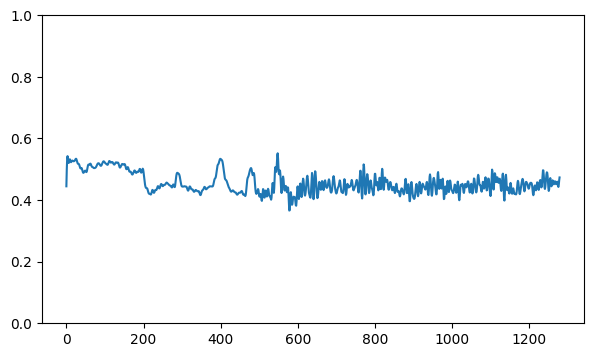

In [ ]:
plt.figure(figsize=(7, 4))
plt.ylim(0, 1)
plt.plot(data_x[0, :, 0])

In [ ]:
data_x = remove_artifacts(data_x, SAMPLES)

In [ ]:
data_y = remove_artifacts(data_y, int(SAMPLES/10))

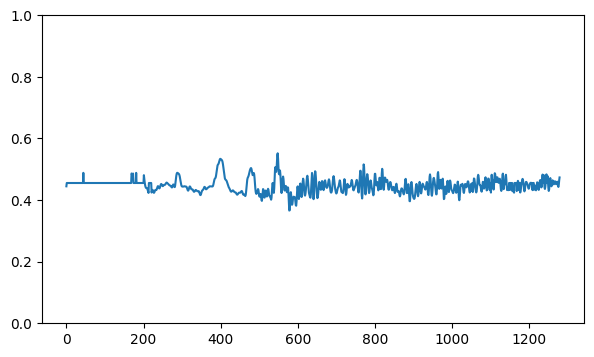

In [ ]:
plt.figure(figsize=(7, 4))
plt.ylim(0, 1)
plt.plot(data_x[0, :, 0])

In [ ]:
data_x = torch.Tensor(data_x)
data_y = torch.Tensor(data_y)
data_loader = DataLoader(
    torch.utils.data.TensorDataset(data_x, data_y), batch_size=16, shuffle=True, num_workers=1
)

In [ ]:
class SequenceLearner(pl.LightningModule):
  def __init__(self, model, lr=0.005):
    super().__init__()
    self.model = model
    self.lr = lr

  def training_step(self, batch, batch_idx):
    x, y = batch
    y_hat, _ = self.model.forward(x)
    y_hat = y_hat.view_as(y)

    result = y_hat.detach().cpu().numpy()[0][0]
    diffs = np.abs(result[1:] - result[:-1])
    diff_mean = np.mean(diffs)

    mse_loss = nn.MSELoss()(y_hat*1000, y*1000)
    slope_loss = (1/diff_mean)/10

    loss = mse_loss
    self.log("train_loss", loss, prog_bar=True)
    return {"loss": loss}

  def validation_step(self, batch, batch_idx):
    x, y = batch
    y_hat, _ = self.model.forward(x)
    y_hat = y_hat.view_as(y)

    result = y_hat.detach().cpu().numpy()[0][0]
    diffs = np.abs(result[1:] - result[:-1])
    diff_mean = np.mean(diffs)

    mse_loss = nn.MSELoss()(y_hat, y)
    slope_loss = (1/diff_mean)/10

    loss = mse_loss
    self.log("val_loss", loss, prog_bar=True)
    return loss

  def test_step(self, batch, batch_idx):
    return self.validation_step(batch, batch_idx)

  def configure_optimizers(self):
    return optim.Adam(self.model.parameters(), lr=self.lr)

In [ ]:
out_features = 5
in_features = 50

wiring = AutoNCP(100, out_features)

ltc_model = LTC(in_features, wiring, batch_first=True)
learn = SequenceLearner(ltc_model, lr=0.01)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=200,
    gradient_clip_val=1,
    log_every_n_steps=1
)

alloc!


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


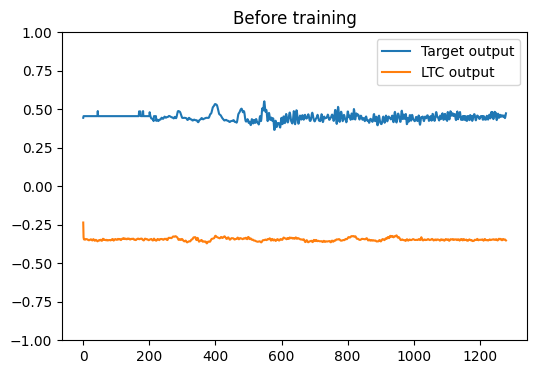

In [ ]:
with torch.no_grad():
  prediction = ltc_model(data_x)[0].numpy()

plt.figure(figsize=(6, 4))
plt.plot(data_x[0, :, 0], label="Target output")
plt.plot(prediction[0, :, 0], label="LTC output")
plt.ylim(-1, 1)
plt.title("Before training")
plt.legend(loc="upper right")
plt.show()

In [ ]:
trainer.fit(learn, data_loader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | LTC  | 75.4 K
-------------------------------
60.4 K    Trainable params
15.0 K    Non-trainable params
75.4 K    Total params
0.302     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


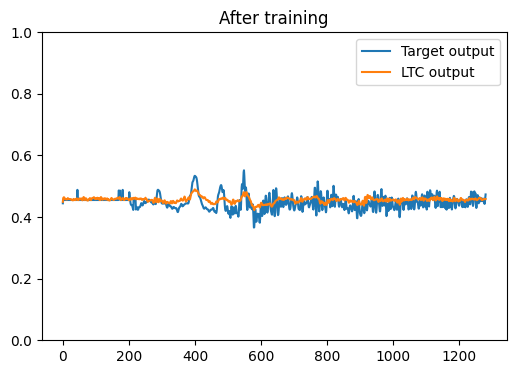

In [ ]:
with torch.no_grad():
  prediction = ltc_model(data_x)[0].numpy()

plt.figure(figsize=(6, 4))
item = 0
plt.plot(data_x[0, :, item], label="Target output")
plt.plot(prediction[0, :, item], label="LTC output")
plt.ylim(0, 1)
plt.title("After training")
plt.legend(loc="upper right")
plt.show()

In [ ]:
seizure_test = []

idx = 0
i = 0
while i < (len(training_data_ltc.data)-50):
  data_seg = np.array(training_data_ltc.data[i : i+50])
  data_seg = np.transpose(data_seg, (1, 2, 0))
  data_seg = torch.Tensor(data_seg)
  seizure_test.append(data_seg)
  i += 5
  idx += 1
  print("{}, {}".format(training_data_ltc.details[i], idx))


Streaming output truncated to the last 5000 lines.
(2, 520448.0, 2033.0), 1845
(2, 521728.0, 2038.0), 1846
(2, 523008.0, 2043.0), 1847
(2, 524288.0, 2048.0), 1848
(2, 525568.0, 2053.0), 1849
(2, 526848.0, 2058.0), 1850
(2, 528128.0, 2063.0), 1851
(2, 529408.0, 2068.0), 1852
(2, 530688.0, 2073.0), 1853
(2, 531968.0, 2078.0), 1854
(2, 533248.0, 2083.0), 1855
(2, 534528.0, 2088.0), 1856
(2, 535808.0, 2093.0), 1857
(2, 537088.0, 2098.0), 1858
(2, 538368.0, 2103.0), 1859
(2, 539648.0, 2108.0), 1860
(2, 540928.0, 2113.0), 1861
(2, 542208.0, 2118.0), 1862
(2, 543488.0, 2123.0), 1863
(2, 544768.0, 2128.0), 1864
(2, 546048.0, 2133.0), 1865
(2, 547328.0, 2138.0), 1866
(2, 548608.0, 2143.0), 1867
(2, 549888.0, 2148.0), 1868
(2, 551168.0, 2153.0), 1869
(2, 552448.0, 2158.0), 1870
(2, 553728.0, 2163.0), 1871
(2, 555008.0, 2168.0), 1872
(2, 556288.0, 2173.0), 1873
(2, 557568.0, 2178.0), 1874
(2, 558848.0, 2183.0), 1875
(2, 560128.0, 2188.0), 1876
(2, 561408.0, 2193.0), 1877
(2, 562688.0, 2198.0), 18

KeyboardInterrupt: 

In [ ]:
print(np.array(training_data_ltc.data[2038]).shape)
print(training_data_ltc.details[2038])

(1, 1280)
(0, 521728.0, 2038.0)


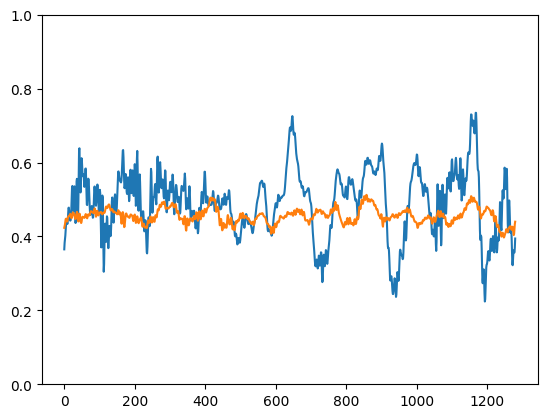

In [ ]:
with torch.no_grad():
  prediction = ltc_model(seizure_test[2039])[0].numpy()

plt.ylim(0, 1)
plt.plot(seizure_test[2039][0,:,0])
plt.plot(prediction[0,:,0])

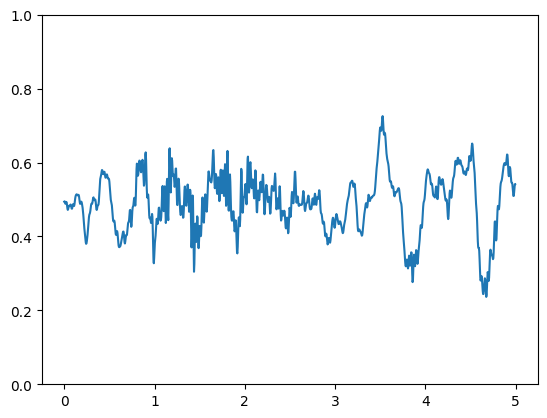

In [ ]:
plt.ylim(0, 1)
plt.plot(training_data_ltc.times[0], training_data_ltc.data[10194][0])


In [ ]:
idx = 0
for i in range(len(seizure_test)):
  if (training_data_ltc.details[idx][0] == 0):
    idx += 5
    continue
  with torch.no_grad():
    prediction = ltc_model(seizure_test[i])[0].numpy()

  print(training_data_ltc.details[idx])
  for j in range(len(prediction[0][0])):
    data_seg = seizure_test[i][0, :, j].numpy()
    pred_seg = prediction[0, :, j]
    mean_percent_error = np.mean(abs(pred_seg-data_seg)/data_seg*100)

    # print(mean_percent_error)
    if (mean_percent_error > 50 and mean_percent_error != float('inf')):
      print(idx)
      print(mean_percent_error)
      plt.figure(figsize=(6, 4))
      plt.plot(data_seg, label="Item")
      plt.plot(pred_seg, label="LTC output")
      plt.ylim(0, 1)
      plt.title("After training")
      plt.legend(loc="upper right")
      plt.show()
      print("Seizure detected.")
  idx += 5

(1, 1024.0, 4.0)
(1, 2304.0, 9.0)
(1, 3584.0, 14.0)
(1, 4864.0, 19.0)
(1, 6144.0, 24.0)
(1, 7424.0, 29.0)
(1, 8704.0, 34.0)
(1, 9984.0, 39.0)
(1, 11264.0, 44.0)
(1, 12544.0, 49.0)
(1, 13824.0, 54.0)
(1, 15104.0, 59.0)
(1, 16384.0, 64.0)
(1, 17664.0, 69.0)
(1, 18944.0, 74.0)
(1, 20224.0, 79.0)
(1, 21504.0, 84.0)
(1, 22784.0, 89.0)
(1, 24064.0, 94.0)
(1, 25344.0, 99.0)
(1, 26624.0, 104.0)
(1, 27904.0, 109.0)
(1, 29184.0, 114.0)
(1, 30464.0, 119.0)
(1, 31744.0, 124.0)
(1, 33024.0, 129.0)
(1, 34304.0, 134.0)
(1, 35584.0, 139.0)
(1, 36864.0, 144.0)
(1, 38144.0, 149.0)
(1, 39424.0, 154.0)
(1, 40704.0, 159.0)
(1, 41984.0, 164.0)
(1, 43264.0, 169.0)
(1, 44544.0, 174.0)
(1, 45824.0, 179.0)
(1, 47104.0, 184.0)
(1, 48384.0, 189.0)
(1, 49664.0, 194.0)
(1, 50944.0, 199.0)
(1, 52224.0, 204.0)
(1, 53504.0, 209.0)
(1, 54784.0, 214.0)
(1, 56064.0, 219.0)
(1, 57344.0, 224.0)
(1, 58624.0, 229.0)
(1, 59904.0, 234.0)
(1, 61184.0, 239.0)
(1, 62464.0, 244.0)
(1, 63744.0, 249.0)
(1, 65024.0, 254.0)
(1, 66304.

<ipython-input-149-c1d7bb3b4eac>:13: RuntimeWarning: divide by zero encountered in divide
  mean_percent_error = np.mean(abs(pred_seg-data_seg)/data_seg*100)


(1, 300544.0, 1174.0)
(1, 301824.0, 1179.0)
(1, 303104.0, 1184.0)
(1, 304384.0, 1189.0)
(1, 305664.0, 1194.0)
(1, 306944.0, 1199.0)
(1, 308224.0, 1204.0)
(1, 309504.0, 1209.0)
(1, 310784.0, 1214.0)
(1, 312064.0, 1219.0)
(1, 313344.0, 1224.0)
(1, 314624.0, 1229.0)
(1, 315904.0, 1234.0)
(1, 317184.0, 1239.0)
(1, 318464.0, 1244.0)
(1, 319744.0, 1249.0)
(1, 321024.0, 1254.0)
(1, 322304.0, 1259.0)
(1, 323584.0, 1264.0)
(1, 324864.0, 1269.0)
(1, 326144.0, 1274.0)
(1, 327424.0, 1279.0)
(1, 328704.0, 1284.0)
(1, 329984.0, 1289.0)
(1, 331264.0, 1294.0)
(1, 332544.0, 1299.0)
(1, 333824.0, 1304.0)
(1, 335104.0, 1309.0)
(1, 336384.0, 1314.0)
(1, 337664.0, 1319.0)
(1, 338944.0, 1324.0)
(1, 340224.0, 1329.0)
(1, 341504.0, 1334.0)
(1, 342784.0, 1339.0)
(1, 344064.0, 1344.0)
(1, 345344.0, 1349.0)
(1, 346624.0, 1354.0)
(1, 347904.0, 1359.0)
(1, 349184.0, 1364.0)
(1, 350464.0, 1369.0)
(1, 351744.0, 1374.0)
(1, 353024.0, 1379.0)
(1, 354304.0, 1384.0)
(1, 355584.0, 1389.0)
(1, 356864.0, 1394.0)
(1, 358144

KeyboardInterrupt: 

No seizures detected in file 1.